## 작성법

1. 1번(Regression)과 2번(Classification) EDA 섹션에 $Expected \ Output$과 유사한(동일할 필요는 없음) 시각화 자료를 출력하는 코드 작성
   - `matplotlib`, `seaborn`, `plotly` 등 시각화 툴은 자유롭게 선택 가능
2. 전처리 및 변수선택은 각자의 아이디어로 진행
3. 교차검증과 하이퍼파라미터 튜닝, 의사결정나무에 대한 예제는 같이 첨부한 `Additional_Resource.ipynb` 참고
4. **코드에 대한 설명을 주석으로 남길 것**

---

In [3427]:
# 수정금지
def seed_everything(seed: int = 42):
    import random
    import numpy as np
    import os

    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

RANDOM_SEED = 42
seed_everything(seed=RANDOM_SEED)

## 1) Regression

### • Dataset

In [3431]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# 데이터셋 불러오기
df = pd.read_csv('data/train_set_1.csv')

In [3433]:
# 전처리 이전의 VIF 계산
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# IF 계산을 위한 데이터 준비 (결측치가 있는 행 제거)
X_vif = df[numeric_cols].dropna()  # 정확한 VIF 계산을 위해 결측치가 있는 행 제거

# VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# # 4. VIF 값 출력
print(vif_data)

# # 5. VIF 값이 10 이상인 변수를 식별 (다중공선성 문제 가능성)
high_vif_columns = vif_data[vif_data["VIF"] >= 10]["feature"]
print("\nVIF가 10 이상인 변수들:\n", high_vif_columns)

                  feature        VIF
0                    hour   7.144876
1    hour_bef_temperature  17.644896
2  hour_bef_precipitation   1.209994
3      hour_bef_windspeed   7.564991
4       hour_bef_humidity   5.849177
5     hour_bef_visibility   7.181911
6          hour_bef_ozone   8.708167
7           hour_bef_pm10   6.105522
8          hour_bef_pm2.5   8.272863
9                   count   6.533357

VIF가 10 이상인 변수들:
 1    hour_bef_temperature
Name: feature, dtype: object


### • EDA (Exploratory Data Analysis)

#### - 출력변수 분포

$Expected \ Output:$

![image](fig/1_1.png)

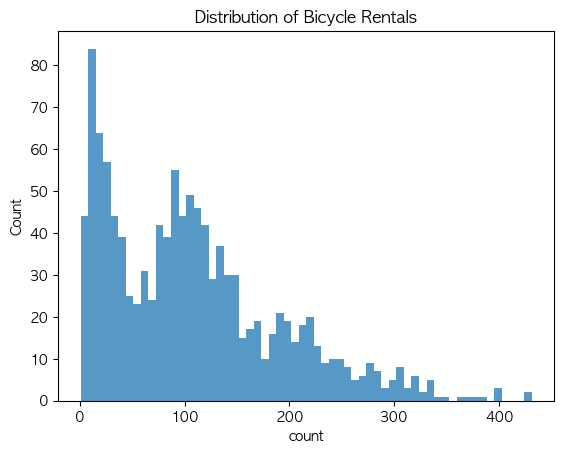

In [3437]:
# 히스토그램 그리기
sns.histplot(df['count'], bins=60, edgecolor=None) 
plt.title('Distribution of Bicycle Rentals')

plt.show()

#### - 결측치 시각화

$Expected \ Output:$

![image](fig/1_2.png)

$Expected \ Output:$

![image](fig/1_3.png)

hour                       0
hour_bef_temperature       2
hour_bef_precipitation     2
hour_bef_windspeed         8
hour_bef_humidity          2
hour_bef_visibility        2
hour_bef_ozone            57
hour_bef_pm10             69
hour_bef_pm2.5            88
count                      0
dtype: int64


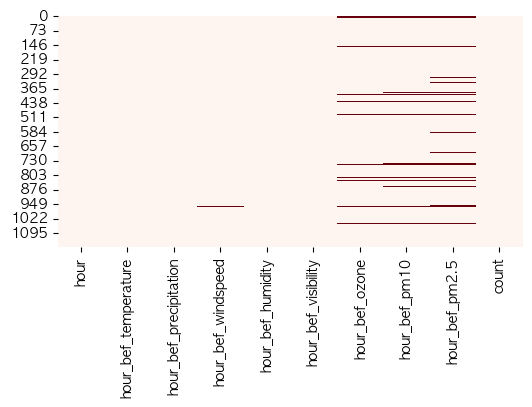

In [3440]:
# 결측치 개수 확인
missing_counts = df.isnull().sum()

# 각 열의 결측치 출력
print(missing_counts[missing_counts >= 0])

# 결측치 시각화
plt.figure(figsize=(6,3))
sns.heatmap(df.isnull(), cbar=False, cmap="Reds")
plt.show()

#### - 입력변수 값 범위

- 스케일링 전

$Expected \ Output:$

![image](fig/1_4.png)

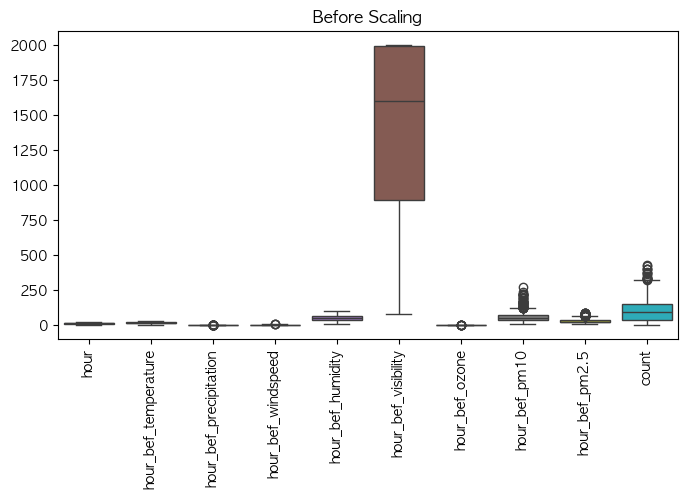

In [3444]:
# 박스플롯 그리기
plt.figure(figsize=(8, 4)) 
sns.boxplot(data=df)
plt.xticks(rotation=90) 
plt.title('Before Scaling') 
plt.show()

- 스케일링 후
  - 스케일링 기법 자유롭게 선택

$Expected \ Output:$

![image](fig/1_5.png)

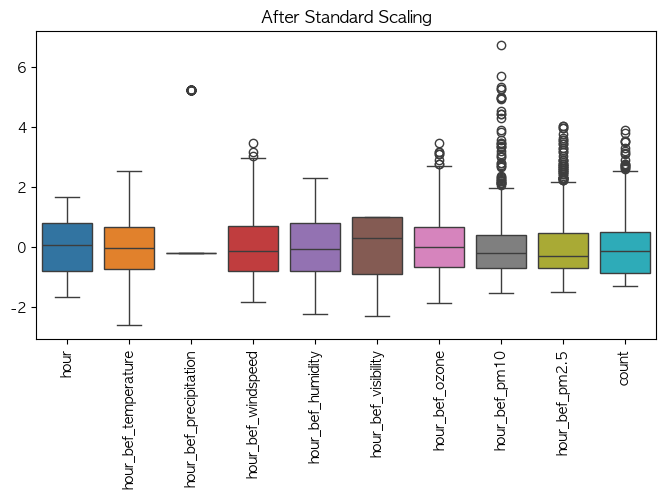

In [3447]:
from sklearn.preprocessing import StandardScaler

# 스케일링을 위한 객체 생성
scaler = StandardScaler()

# 수치형 데이터만 선택
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

# 스케일링 적용
df_scaled = pd.DataFrame(scaler.fit_transform(df[numerical_features]), columns=numerical_features)

# 박스플롯 그리기
plt.figure(figsize=(8, 4))
sns.boxplot(data=df_scaled)
plt.xticks(rotation=90)
plt.title('After Standard Scaling')
plt.show()

#### - 상관관계

- 전체 상관계수 히트맵
    - 상관계수에 절댓값을 씌워야 음의 상관계수도 고려할 수 있음

$Expected \ Output:$

![image](fig/1_6.png)

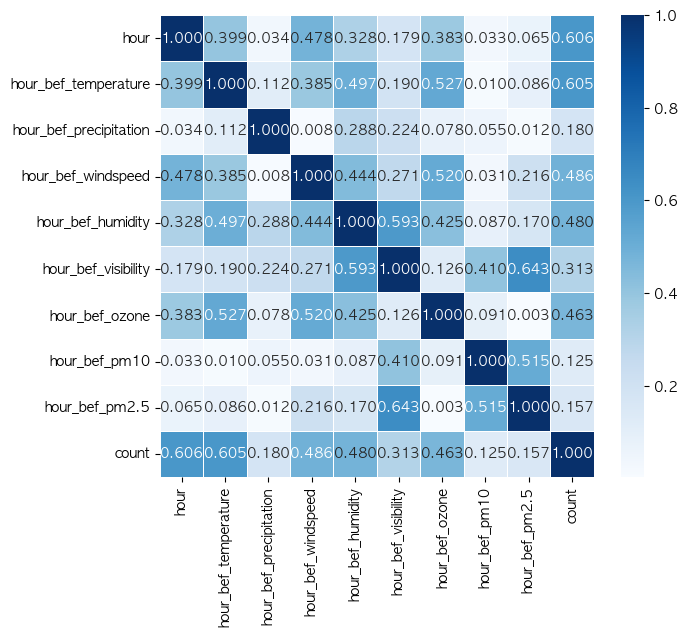

In [3451]:
# 상관관계 행렬 계산
corr_matrix = df.corr().abs() # 절댓값

# 상관관계 히트맵 시각화
plt.figure(figsize=(7, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.3f', linewidths=0.5)
plt.show()

- 출력변수와 상관계수가 가장 높은 입력변수의 상관성

$Expected \ Output:$

![image](fig/1_7.png)

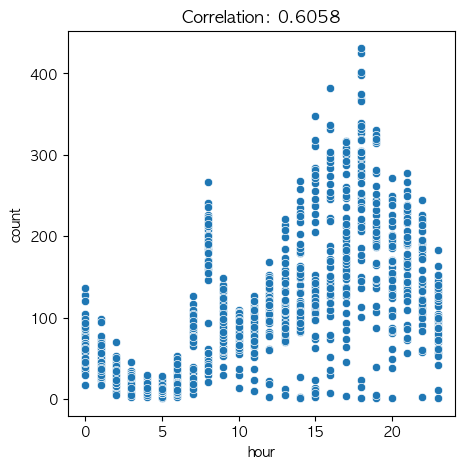

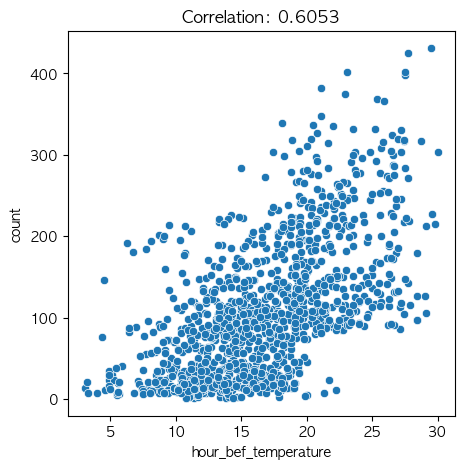

In [3454]:
# hour와 count, hour_bef_temperature와 count의 상관관계가 거의 유사하게 높아 두 경우 모두 출력해 보았다. 

target_variable = 'count'

# hour & count 

# 산점도 그리기
plt.figure(figsize=(5, 5))
sns.scatterplot(x=df['hour'], y=df[target_variable])

# 상관계수 값 표시
plt.title(f'Correlation: {df[['hour', 'count']].corr().loc['hour', 'count']:.4f}')
plt.xlabel('hour')
plt.ylabel(target_variable)
plt.show()

# hour_bef_temperature & count 

# 산점도 그리기
plt.figure(figsize=(5, 5))
sns.scatterplot(x=df['hour_bef_temperature'], y=df[target_variable])

# 상관계수 값 표시
plt.title(f'Correlation: {df[['hour_bef_temperature', 'count']].corr().loc['hour_bef_temperature', 'count']:.4f}')
plt.xlabel('hour_bef_temperature')
plt.ylabel(target_variable)
plt.show()

- 모든 변수들간의 상관성

$Expected \ Output:$

![image](fig/1_8.png)

<Figure size 640x480 with 0 Axes>

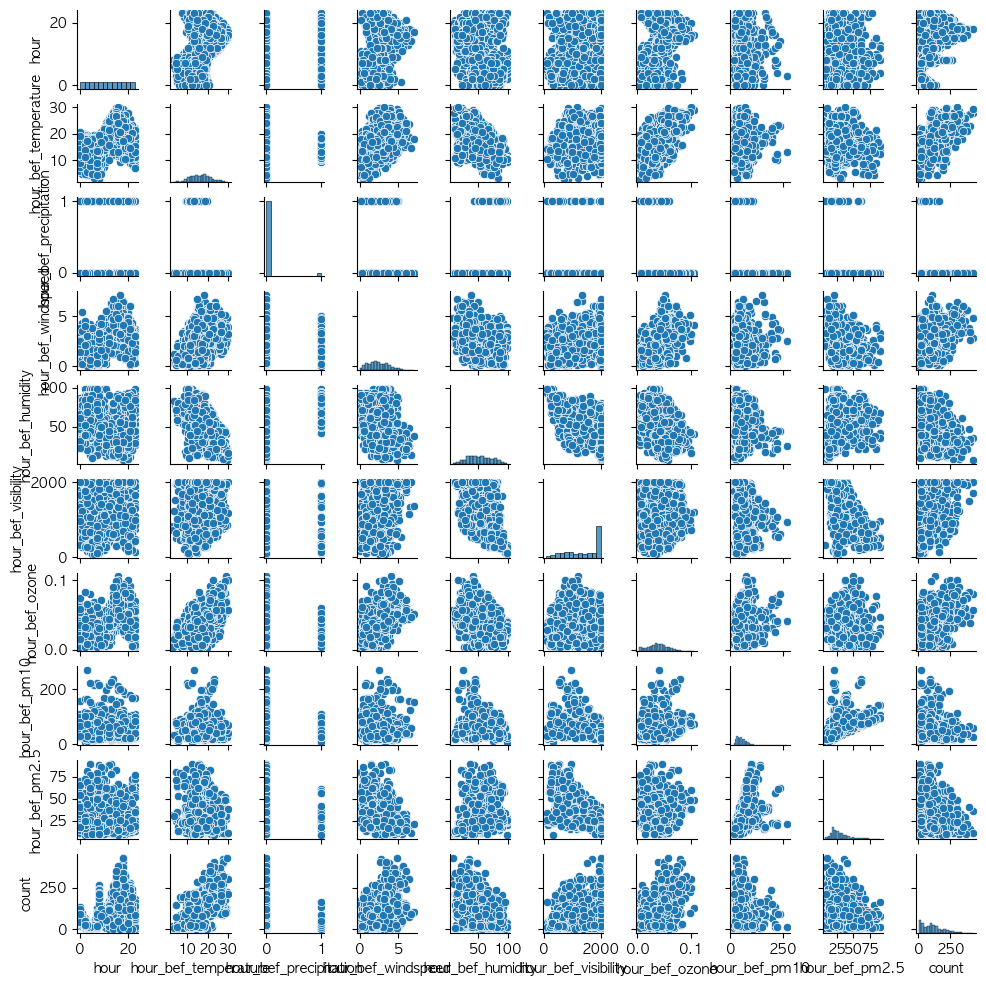

In [3457]:
# 모든 변수 간의 상관성을 시각화
plt.figure() 
sns.pairplot(df, height = 1)
plt.show()

## • Preprocessing

- 전처리는 각자의 전처리 아이디어를 반영하여 진행

In [3459]:
df=pd.read_csv('data/train_set_1.csv')

In [3460]:
# df -> df_cleaned

# 결측치 제거
# 결측치가 있는 행 제거
df_cleaned = df.dropna()

# 각 행의 결측치를 해당 행의 평균값으로 대체
# df_cleaned = df.fillna(df.mean())

# 각 행의 결측치를 해당 행의 중앙값으로 대체
# df_cleaned = df.fillna(df.median())

df_cleaned = df_cleaned.drop(columns=['hour_bef_precipitation']) # 이진 변수이므로 이상치 제거 하지 않음

# 이상치 제거
scaler = StandardScaler()
z_scores = scaler.fit_transform(df_cleaned)
z_scores_df = pd.DataFrame(z_scores, columns=df_cleaned.columns, index=df_cleaned.index)

# 이상치 인덱스 찾기 (z-score 절댓값이 3보다 큰 경우)
outliers_index = z_scores_df[(z_scores_df.abs() > 3).any(axis=1)].index
df_cleaned = df_cleaned.drop(index=outliers_index)

print(f"제거된 row의 개수: {len(outliers_index)}")

# Scaling 전 입력변수 간 다중공선성이 높은 변수 제거 (변수 선택) 
# 다중공선성 제거 (VIF 10 이상인 변수 제거)
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# VIF 계산 및 다중공선성이 높은 변수 제거
vif_data = calculate_vif(df_cleaned)

print("전처리 전의 VIF: \n", vif_data)

# VIF 10 이상인 변수 필터링
high_vif_columns = vif_data[vif_data['VIF'] >= 10]['feature']
df_cleaned = df_cleaned.drop(columns=high_vif_columns)

# hour_bef_temperature, hour_bef_pm10, hour_bef_pm2.5이 선택되었다. 
# 하지만, hour_bef_temperature은 출력변수와의 상관계수가 매우 크기 때문에 제거하지 않기로 결정하였다.
hour_bef_temperature_index = df.columns.get_loc('hour_bef_temperature')
df_cleaned.insert(hour_bef_temperature_index, 'hour_bef_temperature', df['hour_bef_temperature'])

# 변수 스케일링 (Z-Score 변환)
scaled_features = scaler.fit_transform(df_cleaned)
df_scaled = pd.DataFrame(scaled_features, columns=df_cleaned.columns, index=df_cleaned.index)
df_cleaned = df_cleaned.astype('float64') # 경고 제거용
df_cleaned.loc[:, df_cleaned.columns] = df_scaled.astype('float64')

# 'hour_bef_precipitation'열을 다시 df_cleaned에 추가 (범주형 데이터는 스케일링하지 않았음)
hour_bef_precipitation_index = df.columns.get_loc('hour_bef_precipitation')
df_cleaned.insert(hour_bef_precipitation_index, 'hour_bef_precipitation', df['hour_bef_precipitation'])

# 결과 데이터 확인
df_cleaned.head()

제거된 row의 개수: 55
전처리 전의 VIF: 
                 feature        VIF
0                  hour   6.924134
1  hour_bef_temperature  17.202581
2    hour_bef_windspeed   7.685986
3     hour_bef_humidity   5.845872
4   hour_bef_visibility   7.108942
5        hour_bef_ozone   8.704523
6         hour_bef_pm10  10.862570
7        hour_bef_pm2.5  11.800870
8                 count   6.576706


,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,count
0,0.313774,2.279505,0.0,-0.418040,-1.622531,-0.172639,2.354942,0.876658
2,0.755238,-0.420441,1.0,0.198933,1.580439,0.348215,0.300292,-0.201885
5,1.049547,0.773013,0.0,1.432878,-1.672578,0.966621,0.840990,0.701081
7,-1.452079,-1.261728,0.0,-1.651985,1.180068,-1.127249,-1.862497,-0.966898
8,0.313774,1.888208,0.0,-0.263797,-1.222160,0.498026,0.354362,0.500422


In [3461]:
# 번외: 전처리 전/후의 VIF는 크게 다르다?
# 전처리 후의 VIF 계산
numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns

# VIF 계산을 위한 데이터 준비 (결측치가 있는 행 제거)
X_vif = df_cleaned[numeric_cols].dropna()  # 정확한 VIF 계산을 위해 결측치가 있는 행 제거

# VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# # 4. VIF 값 출력
print("전처리 전의 VIF: \n", vif_data)

# # 5. VIF 값이 10 이상인 변수를 식별 (다중공선성 문제 가능성)
high_vif_columns = vif_data[vif_data["VIF"] >= 10]["feature"]
print("\nVIF가 10 이상인 변수들:\n", high_vif_columns)

전처리 전의 VIF: 
                   feature       VIF
0                    hour  1.734483
1    hour_bef_temperature  1.835708
2  hour_bef_precipitation  1.152720
3      hour_bef_windspeed  1.735144
4       hour_bef_humidity  2.501275
5     hour_bef_visibility  1.831002
6          hour_bef_ozone  1.641982
7                   count  2.347751

VIF가 10 이상인 변수들:
 Series([], Name: feature, dtype: object)


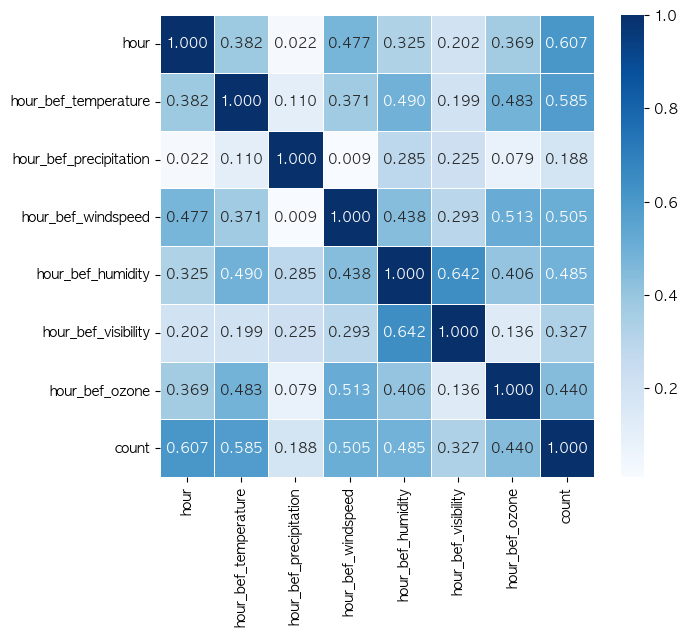

In [3462]:
# 전처리 후의 상관관계 행렬 계산
corr_matrix = df_cleaned.corr().abs() # 절댓값

# 상관관계 히트맵 시각화
plt.figure(figsize=(7, 6))
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt='.3f', linewidths=0.5)
plt.show()

## • Feature Selection

- 상관계수, VIF 등 각자의 변수선택 기법을 사용하여 변수 선택 진행

In [3464]:
# df_cleaned -> df_selected

import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

# 출력변수와의 상관계수가 매우 낮은 입력변수 제거 
corr_matrix = df_cleaned.corr()
low_corr_columns = corr_matrix['count'][abs(corr_matrix['count']) < 0.1].index
print("출력변수와 연관성이 낮은 변수: ", low_corr_columns) # 아무것도 없었음
df_selected = df_cleaned.drop(columns=low_corr_columns)

# 결과 데이터 확인
print("최종 선택된 변수들:", df_selected.columns)

# 최종 선택된 변수들: Index(['hour', 'hour_bef_temperature', 'hour_bef_precipitation',
#        'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
#        'hour_bef_ozone', 'count'],
#       dtype='object')

출력변수와 연관성이 낮은 변수:  Index([], dtype='object')
최종 선택된 변수들: Index(['hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone', 'count'],
      dtype='object')


In [3465]:
# 같은 방식으로 X_test도 전처리 & 변수 선택

test_df = pd.read_csv('data/test_X_1.csv')  # 테스트 데이터 
test_cleaned = test_df.fillna(test_df.median()) # 결측치 중앙값으로 채움
test_cleaned['count'] = 0 # 스케일링을 위해 count 행을 추가 후 모두 0으로 채움

# 'hour_bef_precipitation' 열을 스케일링에서 제외하기 위해 따로 저장
hour_bef_precipitation_index = test_cleaned.columns.get_loc('hour_bef_precipitation')

test_cleaned = test_cleaned.drop(columns=['hour_bef_pm10', 'hour_bef_pm2.5', 'hour_bef_precipitation'])
train_cleaned = df_cleaned.drop(columns=['count', 'hour_bef_precipitation']) # 학습 데이터에서 count 열 제거 (출력변수는 제외)

# 변수 스케일링 (Z-Score 변환)
# 학습된 스케일러를 사용해 test_cleaned도 동일하게 스케일링
z_scores_test = scaler.transform(test_cleaned)
test_cleaned = pd.DataFrame(z_scores_test, columns=test_cleaned.columns, index=test_cleaned.index)

# 'hour_bef_precipitation'열을 다시 test_cleaned에 추가 (범주형 데이터는 스케일링하지 않았음)
test_cleaned.insert(hour_bef_precipitation_index, 'hour_bef_precipitation', test_df['hour_bef_precipitation'])
test_cleaned = test_cleaned.drop(columns=['count'])

# 결과 확인
print(test_cleaned.head())

       hour  hour_bef_temperature  hour_bef_precipitation  hour_bef_windspeed  \
0  0.608083              0.577365                     0.0            2.281215   
1  1.638164             -1.418247                     0.0            0.353176   
2 -1.010615             -0.694348                     0.0           -1.112134   
3 -0.127689              1.281699                     0.0           -0.957891   
4  0.019466              1.183875                     0.0            0.044689   

   hour_bef_humidity  hour_bef_visibility  hour_bef_ozone  
0          -0.721696             0.250664        1.327617  
1          -0.771742             0.966621       -0.132265  
2           1.430300            -1.259640       -1.051451  
3           0.029000             0.356925       -0.943311  
4          -0.771742             0.898684       -0.132265  


## • Regression

In [3474]:
# 데이터셋 불러오기
train_df = df_selected
test_df = test_cleaned

# 훈련 데이터를 입력변수와 출력변수로 분리
X_train = train_df.drop(columns='count')
X_train = sm.add_constant(X_train)
y_train = train_df['count']  

# 테스트 데이터를 입력변수와 출력변수로 분리
X_test = test_df.dropna() # 결측치 제거
X_test = sm.add_constant(X_test)

print(X_train.columns)
print(X_test.columns)

Index(['const', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone'],
      dtype='object')
Index(['const', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone'],
      dtype='object')


In [3476]:
# 다중선형회귀 (검증데이터 없음)

# OLS 모델 구축
regression_model = sm.OLS(y_train, X_train).fit()  # OLS 회귀모델 학습

# 모델 요약 출력
print(regression_model.summary())

# 테스트 데이터로 예측
y_pred = regression_model.predict(X_test)

# 예측 결과 출력
print("테스트 데이터 예측 결과:\n", y_pred)

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.572
Method:                 Least Squares   F-statistic:                     194.0
Date:                Sun, 13 Oct 2024   Prob (F-statistic):          1.20e-181
Time:                        21:59:50   Log-Likelihood:                -1004.4
No. Observations:                1013   AIC:                             2025.
Df Residuals:                    1005   BIC:                             2064.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

### - Ridge and Lasso Regression

- **하이퍼파라미터 후보**:
    - `alpha` = [0.001, 0.01, 0.1, 1, 10]

In [3479]:
import pandas as pd
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

alphas = [0.001, 0.01, 0.1, 1, 10]

# KFold 설정
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# 결과 저장을 위한 딕셔너리
ridge_results = {}
lasso_results = {}

# Ridge와 Lasso에 대해 각 알파 값으로 10-겹 교차 검증 수행
for alpha in alphas:
    ridge_mse_list = []
    lasso_mse_list = []
    
    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        
        # Ridge 모델 학습 및 평가
        ridge_model = Ridge(alpha=alpha)
        ridge_model.fit(X_train_fold, y_train_fold)
        y_val_pred_ridge = ridge_model.predict(X_val_fold)
        ridge_mse = mean_squared_error(y_val_fold, y_val_pred_ridge)
        ridge_mse_list.append(ridge_mse)
        
        # Lasso 모델 학습 및 평가
        lasso_model = Lasso(alpha=alpha, max_iter=10000)
        lasso_model.fit(X_train_fold, y_train_fold)
        y_val_pred_lasso = lasso_model.predict(X_val_fold)
        lasso_mse = mean_squared_error(y_val_fold, y_val_pred_lasso)
        lasso_mse_list.append(lasso_mse)
    
    # 각 알파 값에 대한 Ridge와 Lasso의 평균 MSE 기록
    ridge_results[alpha] = np.mean(ridge_mse_list)
    lasso_results[alpha] = np.mean(lasso_mse_list)

# 결과 출력
print("Ridge 회귀 결과 (평균 MSE):", ridge_results)
print("Lasso 회귀 결과 (평균 MSE):", lasso_results)

# 최적의 알파 값 선택 (가장 낮은 MSE를 갖는 alpha)
best_alpha_ridge = min(ridge_results, key=ridge_results.get)  # Ridge에서 가장 낮은 MSE를 가진 alpha
best_alpha_lasso = min(lasso_results, key=lasso_results.get)  # Lasso에서 가장 낮은 MSE를 가진 alpha

# 최적의 알파 값으로 Ridge 및 Lasso 모델 학습
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)

lasso_model = Lasso(alpha=best_alpha_lasso, max_iter=10000)
lasso_model.fit(X_train, y_train)

# 최적의 모델 출력
print(f"최적의 Ridge 모델 (alpha={best_alpha_ridge})")
print(f"최적의 Lasso 모델 (alpha={best_alpha_lasso})")

# 결과 테이블 출력
results_df = pd.DataFrame({
    'alpha': alphas,
    'Ridge MSE': [ridge_results[alpha] for alpha in alphas],
    'Lasso MSE': [lasso_results[alpha] for alpha in alphas]
})

print("\n결과 테이블:\n", results_df)


Ridge 회귀 결과 (평균 MSE): {0.001: 0.43362562455018444, 0.01: 0.43362526688409825, 0.1: 0.4336218662371733, 1: 0.4336043257675522, 10: 0.4343450409778683}
Lasso 회귀 결과 (평균 MSE): {0.001: 0.43365441470327754, 0.01: 0.43683864896689456, 0.1: 0.46875150188234044, 1: 1.0045397086329557, 10: 1.0045397086329557}
최적의 Ridge 모델 (alpha=1)
최적의 Lasso 모델 (alpha=0.001)

결과 테이블:
     alpha  Ridge MSE  Lasso MSE
0   0.001   0.433626   0.433654
1   0.010   0.433625   0.436839
2   0.100   0.433622   0.468752
3   1.000   0.433604   1.004540
4  10.000   0.434345   1.004540


### - Decision Tree Regression

- 의사결정나무의 하이퍼파라미터 튜닝은 sklearn의 `RandomizedSearchCV`을 기본으로 함 ([하이퍼파라미터 튜닝 참고](https://dacon.io/codeshare/4568?page&dtype&ptype))

> **⚠️ 주의사항**: `GridSearchCV`는 search space가 클 경우 매우 오래걸림

- **하이퍼파라미터 후보**:
    - `max_depth` = [None, 1, 5, 10, 50]
    - `max_leaf_nodes` = [None, 2, 5, 10, 50]
    - `max_features` = [None, 0.2, 0.4, 0.6, 0.8, 1.0]
    - `min_samples_split` = [0.2, 0.4, 0.6, 0.8, 1.0]
    - `min_samples_leaf` = [0.1, 0.3, 0.5, 0.7, 0.9]
- 하이퍼파라미터 튜닝 평가지표: `scoring='neg_mean_squared_error'`
    - `neg_mean_squared_error`는 $MSE$가 음수로 나오기 때문에 양수로 변환시켜야함

> **주의사항**:
> 
> 의사결정나무 모델 생성시 시드 설정
> ```python
> >>> dt = DecisionTreeRegressor(..., random_state=RANDOM_SEED)  # RANDOM_SEED = 42
> ```

Best hyperparameters:
 {'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 50, 'max_features': None, 'max_depth': 10}
Best MSE: 0.4259
|--- hour <= -0.64
|   |--- hour_bef_temperature <= -0.27
|   |   |--- hour_bef_humidity <= 0.90
|   |   |   |--- value: [-0.96]
|   |   |--- hour_bef_humidity >  0.90
|   |   |   |--- value: [-1.06]
|   |--- hour_bef_temperature >  -0.27
|   |   |--- value: [-0.79]
|--- hour >  -0.64
|   |--- hour_bef_temperature <= 0.25
|   |   |--- hour_bef_visibility <= 0.43
|   |   |   |--- value: [-0.18]
|   |   |--- hour_bef_visibility >  0.43
|   |   |   |--- value: [0.22]
|   |--- hour_bef_temperature >  0.25
|   |   |--- hour <= 0.53
|   |   |   |--- value: [0.36]
|   |   |--- hour >  0.53
|   |   |   |--- value: [1.24]



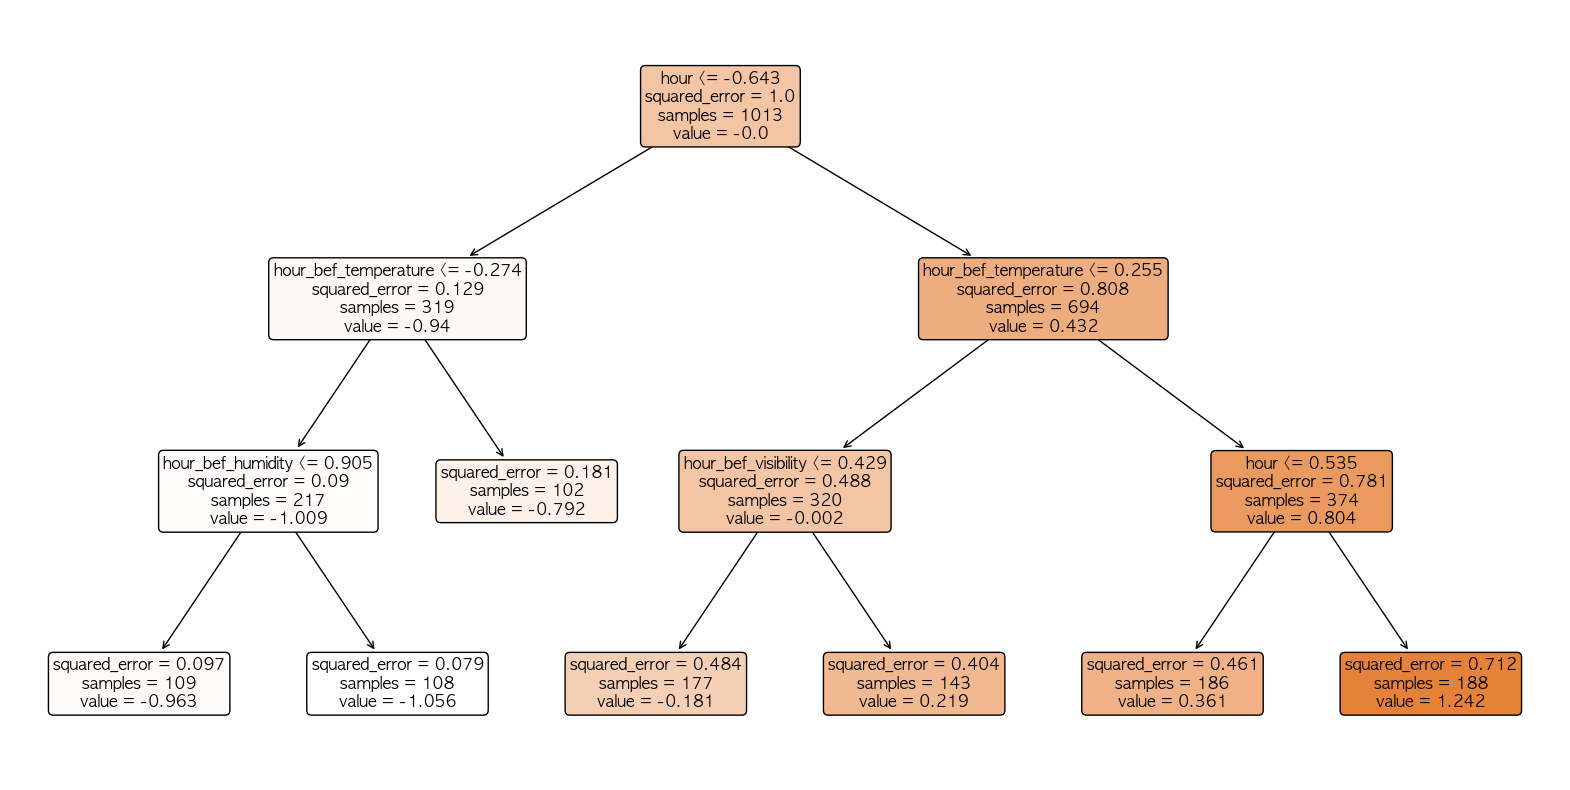

Predicted values for X_test:
 [ 1.24208698  0.218903   -1.0560794   0.36058106  0.36058106 -0.79168972
 -0.18119532  1.24208698 -0.79168972 -0.96333082  0.36058106  1.24208698
 -0.18119532 -0.18119532 -0.18119532 -0.18119532  0.36058106  1.24208698
 -0.18119532  0.218903   -0.18119532  0.36058106  0.218903   -0.18119532
 -1.0560794   0.36058106  1.24208698 -0.18119532  0.36058106 -0.18119532
  0.36058106 -0.18119532 -0.18119532  0.218903   -0.18119532  0.36058106
  0.218903   -1.0560794   0.36058106  0.218903   -0.96333082 -0.96333082
  1.24208698 -0.79168972  1.24208698 -1.0560794  -1.0560794   1.24208698
 -0.96333082  1.24208698 -0.79168972 -0.96333082  1.24208698  0.36058106
 -1.0560794  -0.96333082  1.24208698  0.218903    1.24208698 -0.96333082
  1.24208698 -0.96333082 -1.0560794  -0.79168972 -0.79168972  1.24208698
 -1.0560794   0.218903   -0.96333082 -0.79168972  0.36058106 -0.79168972
 -0.79168972 -0.96333082 -0.18119532 -0.18119532  1.24208698 -0.96333082
  0.36058106 -0.18119

In [3482]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, export_text, plot_tree
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

param_dist = {
    'max_depth': [None, 1, 5, 10, 50],
    'max_leaf_nodes': [None, 2, 5, 10, 50],
    'max_features': [None, 0.2, 0.4, 0.6, 0.8, 1.0],
    'min_samples_split': [0.2, 0.4, 0.6, 0.8, 1.0],
    'min_samples_leaf': [0.1, 0.3, 0.5, 0.7, 0.9]
}

dt_regressor = DecisionTreeRegressor(random_state=42)

# RandomizedSearchCV 사용
random_search = RandomizedSearchCV(
    cv=10, 
    estimator=dt_regressor,
    n_iter=1000,
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

# Decision Tree 모델 학습
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 MSE 출력
print("Best hyperparameters:\n", random_search.best_params_)
print(f"Best MSE: {-random_search.best_score_:.4f}")

# 결과 테이블 생성
results_df = pd.DataFrame(random_search.cv_results_)
best_result = results_df.loc[random_search.best_index_]

# 트리 구조를 텍스트로 출력
dt_model = random_search.best_estimator_
tree_rules = export_text(dt_model, feature_names=list(X_train.columns))
print(tree_rules)

# 트리 구조를 그래픽으로 시각화
plt.figure(figsize=(20,10))
plot_tree(best_model, feature_names=X_train.columns, filled=True, rounded=True)
plt.show()

# 전체 결과 출력 
y_pred_test = dt_model.predict(X_test)
print("Predicted values for X_test:\n", y_pred_test)

In [3483]:
missing_cols = set(X_train.columns) - set(X_test.columns)  # X_test에 없는 열 찾기
for col in missing_cols:
    X_test[col] = 0  # 없는 열을 0으로 채움

# X_train과 동일한 열 순서를 유지
X_test = X_test[X_train.columns]

print(X_train.columns)
print(X_test.columns)

print(X_train.dtypes)
print(X_test.dtypes)

Index(['const', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone'],
      dtype='object')
Index(['const', 'hour', 'hour_bef_temperature', 'hour_bef_precipitation',
       'hour_bef_windspeed', 'hour_bef_humidity', 'hour_bef_visibility',
       'hour_bef_ozone'],
      dtype='object')
const                     float64
hour                      float64
hour_bef_temperature      float64
hour_bef_precipitation    float64
hour_bef_windspeed        float64
hour_bef_humidity         float64
hour_bef_visibility       float64
hour_bef_ozone            float64
dtype: object
const                     float64
hour                      float64
hour_bef_temperature      float64
hour_bef_precipitation    float64
hour_bef_windspeed        float64
hour_bef_humidity         float64
hour_bef_visibility       float64
hour_bef_ozone            float64
dtype: object


In [3484]:
# 7. & 8.

import pandas as pd
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Multi-Linear Regression (MLR) 모델 예측
y_pred_mlr = regression_model.predict(X_test)

# Ridge 모델 예측
y_pred_ridge = ridge_model.predict(X_test)

# Lasso 모델 예측
y_pred_lasso = lasso_model.predict(X_test)

# Decision Tree 모델 예측
y_pred_dt = dt_model.predict(X_test)

# 정규화를 역변환 + 음수가 나올 경우 0으로 예측
# 평균과 표준편차 출력
y_mean = scaler.mean_[-1]
y_std = scaler.scale_[-1]

# Multi-Linear Regression (MLR) 모델 예측
y_pred_mlr_original = np.maximum(y_pred_mlr * y_std + y_mean, 0)

# Ridge 모델 예측
y_pred_ridge_original = np.maximum(y_pred_ridge * y_std + y_mean, 0)

# Lasso 모델 예측
y_pred_lasso_original = np.maximum(y_pred_lasso * y_std + y_mean, 0)

# Decision Tree 모델 예측
y_pred_dt_original = np.maximum(y_pred_dt * y_std + y_mean, 0)


# 예측 결과를 DataFrame에 추가
results_df_original = pd.DataFrame({
    'MLR': y_pred_mlr_original,
    'Ridge': y_pred_ridge_original,
    'Lasso': y_pred_lasso_original,
    'Decision Tree Regression': y_pred_dt_original
})

# 결과를 CSV로 저장
results_df_original.to_csv('data/2019147029_조은기_regression.csv', header=True, index=False)

# 결과 확인
print("\n최종 예측 결과 테이블:\n", results_df_original)


최종 예측 결과 테이블:
             MLR       Ridge       Lasso  Decision Tree Regression
0    178.134277  178.055335  177.883911                208.138298
1    136.370368  136.337646  136.259382                126.552448
2     34.308164   34.156906   34.242996                 24.888889
3    128.753013  128.679258  128.713872                137.849462
4    150.633181  150.635832  150.598196                137.849462
..          ...         ...         ...                       ...
287   71.160385   71.059570   71.060433                 45.970588
288  171.426867  171.365029  171.304715                208.138298
289  152.377697  152.174736  152.073174                208.138298
290   68.578461   68.734607   68.737752                 45.970588
291    0.000000    0.000000    0.000000                 45.970588

[292 rows x 4 columns]


## 2) Classification

### • Dataset

In [2991]:
# 데이터셋 불러오기
df = pd.read_csv('data/train_set_2.csv')

### • EDA (Exploratory Data Analysis)

#### - 클래스 균형 시각화

$Expected \ Output:$

- `red`, `white` 순서 상관없음

![image](fig/2_1.png)

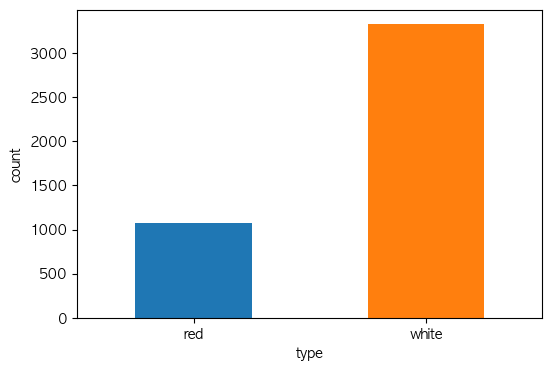

In [2995]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
df['type'].value_counts(ascending=True).plot(kind='bar', color=['#1f77b4', '#ff7f0e'])
plt.xlabel('type')
plt.ylabel('count')
plt.xticks(rotation=0)
plt.show()

#### - 결측치 시각화


$Expected \ Output:$

![image](fig/2_2.png)

$Expected \ Output:$

![image](fig/2_3.png)

quality                 0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
type                    0
dtype: int64


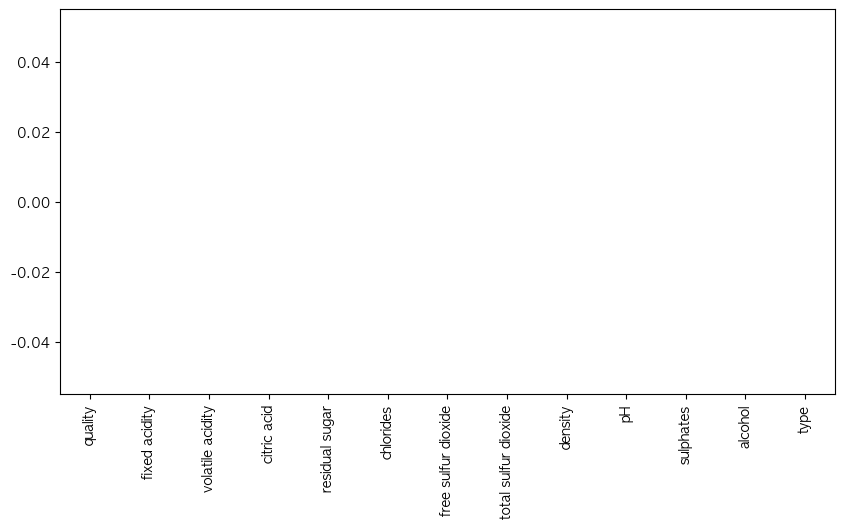

In [2998]:
missing_values = df.isnull().sum()
print(missing_values)

# 결측치 시각화
plt.figure(figsize=(10,5))
missing_values.plot(kind='bar')  
plt.show()

#### - 입력변수 값 범위

- 스케일링 전

$Expected \ Output:$

![image](fig/2_4.png)

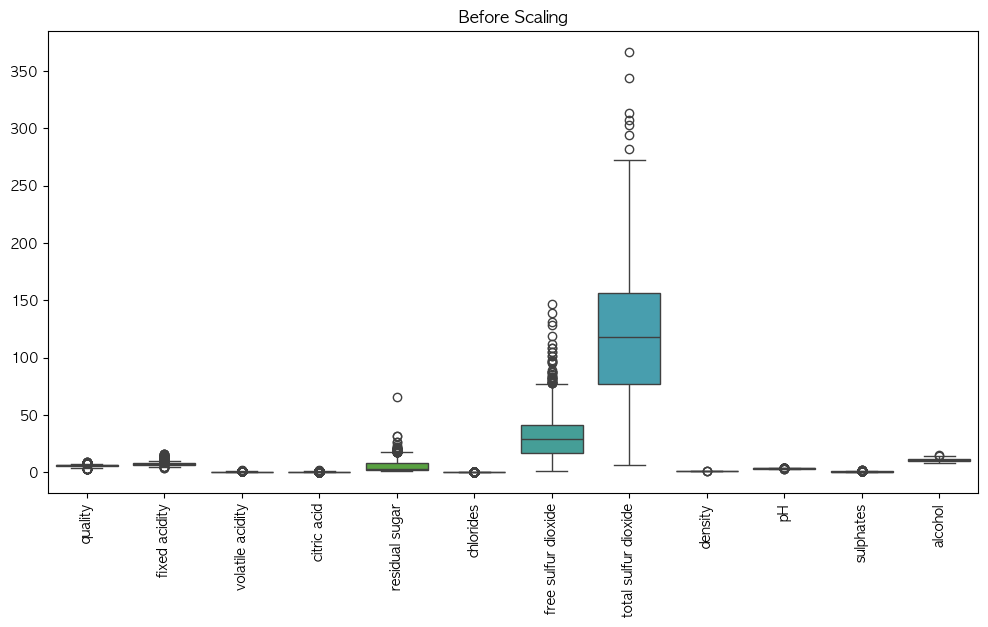

In [3000]:
# 입력변수 값 범위

plt.figure(figsize=(12,6))
sns.boxplot(data=df)
plt.title('Before Scaling')
plt.xticks(rotation=90)
plt.show()

- 스케일링 후
  - 스케일링 기법 자유롭게 선택
  
$Expected \ Output:$

![image](fig/2_5.png)

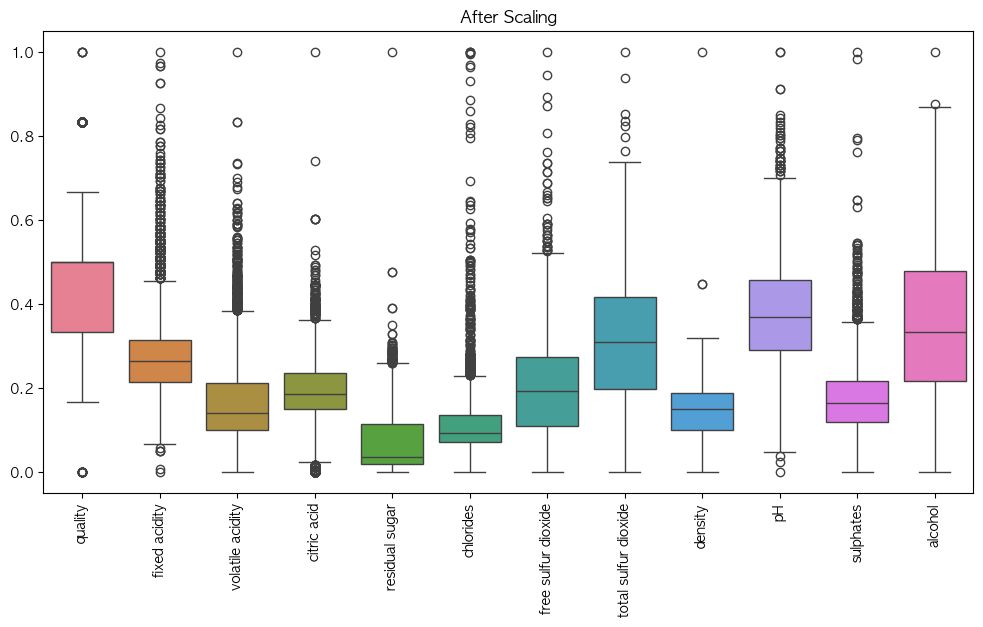

In [3002]:
from sklearn.preprocessing import MinMaxScaler

# Min-Max Scaling
numeric_df = df.select_dtypes(include=['float64', 'int64'])


# Min-Max Scaling 적용
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(numeric_df), columns=numeric_df.columns)


# 시각화
plt.figure(figsize=(12,6))
sns.boxplot(data=df_scaled)
plt.title('After Scaling')
plt.xticks(rotation=90)
plt.show()

#### 상관관계

- 전체 상관계수 히트맵

$Expected \ Output:$

![image](fig/2_6.png)

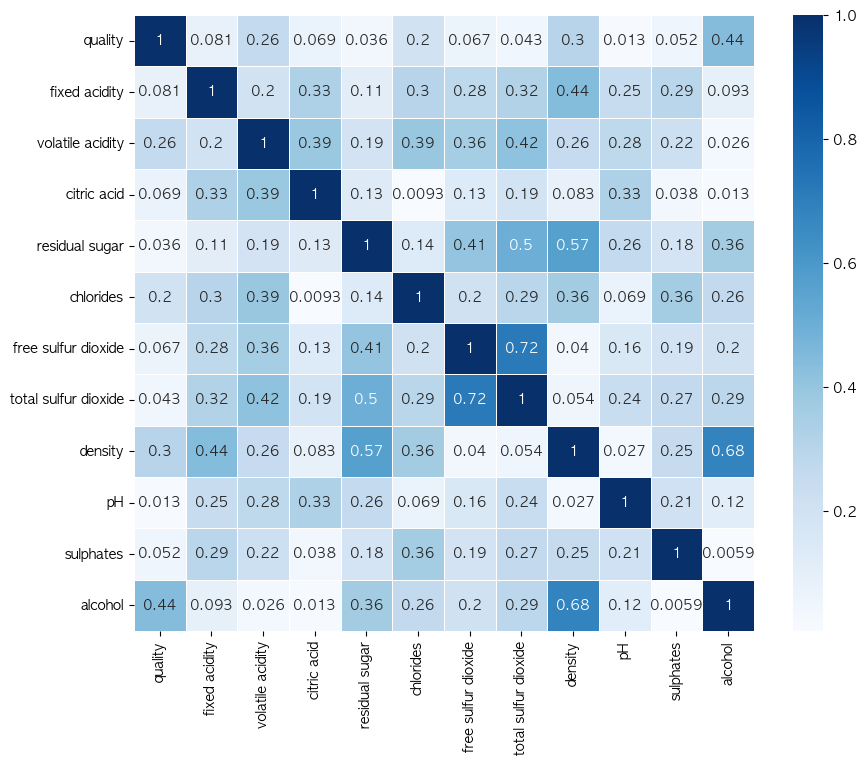

In [3004]:
# 수치형 데이터만 선택
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# 상관관계 행렬 계산
correlation_matrix = numeric_df.corr().abs()

# 상관계수 히트맵 출력
plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', linewidths=0.5)
plt.show()

In [3008]:
# 전처리 전의 VIF 계산
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# VIF 계산을 위한 데이터 준비 (결측치가 있는 행 제거)
X_vif = df[numeric_cols].dropna()  # 정확한 VIF 계산을 위해 결측치가 있는 행 제거

# VIF 계산
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# # 4. VIF 값 출력
print(vif_data)

# # 5. VIF 값이 10 이상인 변수를 식별 (다중공선성 문제 가능성)
high_vif_columns = vif_data[vif_data["VIF"] >= 10]["feature"]
print("\nVIF가 10 이상인 변수들:\n", high_vif_columns)

# VIF가 10 이상인 변수들:
#  0                  quality
# 1            fixed acidity
# 7     total sulfur dioxide
# 8                  density
# 9                       pH
# 10               sulphates
# 11                 alcohol
# Name: feature, dtype: object

# 입력변수 간 상관계수가 높은 열 모두 제거

                 feature         VIF
0                quality   63.949240
1          fixed acidity   59.778559
2       volatile acidity    9.595809
3            citric acid    9.266862
4         residual sugar    3.586170
5              chlorides    5.985270
6    free sulfur dioxide    8.643180
7   total sulfur dioxide   14.717174
8                density  951.303260
9                     pH  593.810001
10             sulphates   18.702549
11               alcohol  133.501405

VIF가 10 이상인 변수들:
 0                  quality
1            fixed acidity
7     total sulfur dioxide
8                  density
9                       pH
10               sulphates
11                 alcohol
Name: feature, dtype: object


## • Preprocessing

- 전처리는 각자의 아이디어를 반영하여 진행

In [3388]:
# 데이터셋 불러오기
df = pd.read_csv('data/train_set_2.csv')

In [3390]:
# df -> df_cleaned
# 결측치는 앞서 없는 것을 확인했기 때문에 결측치 제거는 하지 않았음.

import pandas as pd
from sklearn.preprocessing import StandardScaler

# 수치형 변수 선택 (출력변수는 선택안됨)
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols_no_quality = numeric_cols.drop('quality')  # 'quality' 열은 범주형이므로 제외

# 먼저 수치형 변수를 float64로 변환 (타입 변환)
df[numeric_cols_no_quality] = df[numeric_cols_no_quality].astype('float64')

# 1. 이상치 제거 (IQR 방식)

# 이상치 제거 전 행의 개수
initial_row_count = df.shape[0]

# Z-Score 계산을 위해 StandardScaler 사용
scaler = StandardScaler()
scaled_numeric_features = scaler.fit_transform(df[numeric_cols_no_quality])

# Z-Score 데이터프레임 생성
df_scaled = pd.DataFrame(scaled_numeric_features, columns=numeric_cols_no_quality)

# Z-Score가 3을 넘는 데이터 제거
df_cleaned = df[~(df_scaled.abs() > 3).any(axis=1)].copy()

cleaned_row_count = df_cleaned.shape[0]
removed_row_count = initial_row_count - cleaned_row_count

# 결과 출력
print(f"이상치 제거 전 전체 행의 수: {initial_row_count}")
print(f"제거된 행의 수: {removed_row_count}")
print(df_cleaned['type'].value_counts())

# 결측치 제거 (데이터에 결측치가 없기 때문에 생략해도 됨)
df_cleaned = df_cleaned.dropna()

# 변수 스케일링 (Z-Score 변환)
numeric_cols_with_quality = numeric_cols  # quality도 스케일링에는 포함
scaled_features = scaler.fit_transform(df_cleaned[numeric_cols_with_quality])
df_scaled = pd.DataFrame(scaled_features, columns=numeric_cols_with_quality)

# 기존 데이터에 스케일링한 수치형 변수 반영
df_cleaned[numeric_cols_with_quality] = df_scaled.astype('float64')

# encoding
encoding = {'type': {'red': 1, 'white': 0}}
df_cleaned.replace(encoding, inplace=True)

# 전처리된 데이터 결과 확인
df_cleaned.head()

이상치 제거 전 전체 행의 수: 4397
제거된 행의 수: 329
type
white    3204
red       864
Name: count, dtype: int64


/var/folders/53/7lp11kbs72x7jvqmh0y_6_gh0000gn/T/ipykernel_13038/1183654012.py:50: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cleaned.replace(encoding, inplace=True)


,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,-0.972446,-0.277426,-0.168937,-0.703990,0.147792,0.429250,0.655911,1.329159,1.436953,-0.255974,-0.075058,-1.104792,0
1,0.182564,-0.277426,0.731676,-0.404112,-0.067055,-0.403318,0.594072,1.071737,-1.163578,-0.321031,-0.862007,1.485850,0
2,0.182564,-0.469523,-0.653883,-0.104235,2.016966,-0.011521,0.161196,0.005273,1.356344,-1.166770,0.161027,-1.271930,0
3,-0.972446,1.739592,-0.099659,0.345582,-0.625659,0.233352,-1.261110,-1.447325,0.399545,1.175278,1.341449,1.068005,1
4,0.182564,-0.565572,-0.376771,-0.404112,0.577487,-0.452293,-0.580877,0.281082,0.574783,1.370449,0.947975,-0.603377,0


## • Feature Selection

- 상관계수, VIF 등 각자의 변수선택 기법을 사용하여 변수 선택 진행

In [3393]:
# df_cleaned -> df_selected

import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np

numeric_cols = df_cleaned.select_dtypes(include=['float64', 'int64']).columns
X_vif = df_cleaned[numeric_cols].dropna()

df_selected = X_vif.drop(columns=['alcohol', 'total sulfur dioxide', 'density', 'pH', 'fixed acidity', 'quality', 'sulphates'])

# 4. 'type 변수를 다시 추가
df_selected['type'] = df_cleaned['type']

# 결과 데이터 확인
print("최종 선택된 변수들:", df_selected.columns)

# 최종 선택된 변수들: Index(['volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
#        'free sulfur dioxide', 'type'],
#       dtype='object')

print(df_selected.head())

최종 선택된 변수들: Index(['volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
       'free sulfur dioxide', 'type'],
      dtype='object')
   volatile acidity  citric acid  residual sugar  chlorides  \
0         -0.168937    -0.703990        0.147792   0.429250   
1          0.731676    -0.404112       -0.067055  -0.403318   
2         -0.653883    -0.104235        2.016966  -0.011521   
3         -0.099659     0.345582       -0.625659   0.233352   
4         -0.376771    -0.404112        0.577487  -0.452293   

   free sulfur dioxide  type  
0             0.655911     0  
1             0.594072     0  
2             0.161196     0  
3            -1.261110     1  
4            -0.580877     0  


## • Modeling

> **⚠️ 주의사항**: 분석에 들어가기 전 문자열로 되어있는 출력변수 'type'을 인코딩 시켜야함
> - `'red'`는 1로 변환
> - `'white'`는 0으로 변환

**평가지표**: 모든 분류모델의 평가지표는 $F1 \ Score$으로 함

In [3396]:
# 테스트 데이터도 전처리 및 변수 선택 진행

df_test = pd.read_csv('data/test_X_2.csv')
test_cleaned = test_df.fillna(test_df.median()) # 결측치 중앙값으로 채움

# type column을 추가하고 모든 값을 0으로 설정
test_cleaned['type'] = 0

# 동일한 열 제거
test_cleaned = df_test.drop(columns=['alcohol', 'total sulfur dioxide', 'density', 'pH', 'fixed acidity', 'quality', 'sulphates'])

# 앞서 저장되어 있는 scaler 변수에 따라 스케일링 진행
numeric_cols_test = df_test.select_dtypes(include=['float64', 'int64']).columns
scaled_features_test = scaler.transform(df_test)

test_cleaned = pd.DataFrame(scaled_features_test, columns=numeric_cols_test, index=df_test.index)

test_cleaned.head()

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.337574,-0.565572,-1.277384,0.045704,-0.604174,-0.697166,-0.766395,-0.527960,-0.728988,1.175278,1.734924,0.817297
1,2.492584,-1.237911,-0.030381,-0.254174,-0.260418,-0.942039,0.965108,-0.049889,-1.759386,-0.386087,0.397111,2.070833
2,-0.972446,0.394913,2.775375,-2.053440,-0.861991,1.212844,-1.384789,-1.888621,0.210288,0.264482,0.082332,-0.770515
3,-0.972446,4.236852,0.593120,1.545092,-0.539720,1.408742,-0.086162,-1.153128,1.969676,0.264482,2.836652,0.399452
4,0.182564,0.298865,-1.277384,-0.104235,-0.904961,-0.893064,-0.333519,-0.491185,-0.630854,2.021018,-1.019396,0.065176


In [3398]:
# 데이터 불러오기
train_df = df_selected
test_df = test_cleaned

# 훈련 데이터를 입력변수와 출력변수로 분리
X_train = train_df.drop(columns='type')
# X_train = sm.add_constant(X_train)
y_train = train_df['type']  

# 테스트 데이터를 입력변수와 출력변수로 분리
# X_test = sm.add_constant(test_df)

# X_train에는 없고, X_test에는 있는 열을 찾아서 제거
extra_columns_in_test = set(X_test.columns) - set(X_train.columns)
X_test = X_test.drop(columns=extra_columns_in_test)

print("X_train: \n", X_train.head())
print("y_train: \n", y_train.head())
print("X_test: \n", X_test.head())

X_train: 
    volatile acidity  citric acid  residual sugar  chlorides  \
0         -0.168937    -0.703990        0.147792   0.429250   
1          0.731676    -0.404112       -0.067055  -0.403318   
2         -0.653883    -0.104235        2.016966  -0.011521   
3         -0.099659     0.345582       -0.625659   0.233352   
4         -0.376771    -0.404112        0.577487  -0.452293   

   free sulfur dioxide  
0             0.655911  
1             0.594072  
2             0.161196  
3            -1.261110  
4            -0.580877  
y_train: 
 0    0
1    0
2    0
3    1
4    0
Name: type, dtype: int64
X_test: 
    volatile acidity  citric acid  residual sugar  chlorides  \
0         -1.385205     0.026582       -0.642528  -0.628475   
1          0.211410    -0.372586       -0.284863  -0.940073   
2          3.803795    -2.767590       -0.910776   1.801983   
3          1.009718     2.022418       -0.575466   2.051261   
4         -1.385205    -0.173002       -0.955485  -0.877753   



In [3400]:
# X_test에서 결측치가 있는지 확인
print("X_test 결측치 개수:\n", X_test.isnull().sum())

# 결측치가 있는 행 제거
X_test = X_test.dropna()

X_test 결측치 개수:
 volatile acidity       0
citric acid            0
residual sugar         0
chlorides              0
free sulfur dioxide    0
dtype: int64


### - Logistic Regression

- **하이퍼파라미터 후보**:
    - `C` = [0.01, 0.1, 1, 10]

In [3403]:
from imblearn.under_sampling import RandomUnderSampler

# data imbalance 개선
X_train, y_train = RandomUnderSampler(random_state=RANDOM_SEED).fit_resample(X_train,y_train)

In [3405]:
# 각각의 행 수 출력
print(f"X_train 행의 수: {X_train.shape[0]}")
print(f"y_train 행의 수: {y_train.shape[0]}")
print(y_train.value_counts())

X_train 행의 수: 1620
y_train 행의 수: 1620
type
0    810
1    810
Name: count, dtype: int64


In [3409]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

logreg = LogisticRegression(max_iter=1000)

# 하이퍼파라미터 후보 정의 (C 값)
param_grid = {'C': [0.01, 0.1, 1, 10]}

# GridSearchCV를 사용한 하이퍼파라미터 튜닝
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1')  # F1 스코어 기준으로 최적화
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 확인
print("최적의 C 값:", grid_search.best_params_)

# 최적 모델 저장
classification_model = grid_search.best_estimator_

# 각 하이퍼파라미터 값에 따른 F1 스코어 출력
print("\n각 하이퍼파라미터에 따른 F1 스코어:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['params']

for mean, std, param in zip(means, stds, params):
    print(f"하이퍼파라미터: {param}, 평균 F1 스코어: {mean:.3f} (표준편차: {std:.3f})")

최적의 C 값: {'C': 1}

각 하이퍼파라미터에 따른 F1 스코어:
하이퍼파라미터: {'C': 0.01}, 평균 F1 스코어: 0.505 (표준편차: 0.022)
하이퍼파라미터: {'C': 0.1}, 평균 F1 스코어: 0.505 (표준편차: 0.023)
하이퍼파라미터: {'C': 1}, 평균 F1 스코어: 0.506 (표준편차: 0.024)
하이퍼파라미터: {'C': 10}, 평균 F1 스코어: 0.506 (표준편차: 0.024)


### - KNN Classification

- **하이퍼파라미터 후보**:
    - `n_neighbors` = [1, 3, 5, 7]

In [3417]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# KNN 모델 정의
knn = KNeighborsClassifier()

# 하이퍼파라미터 후보 정의 (n_neighbors 값)
param_grid = {'n_neighbors': [1, 3, 5, 7]}

# GridSearchCV를 사용한 하이퍼파라미터 튜닝
grid_search = GridSearchCV(knn, param_grid, cv=10, scoring='f1')  # F1 스코어 기준으로 최적화
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 확인
print("최적의 n_neighbors 값:", grid_search.best_params_)

# 최적의 모델 저장
knn_model = grid_search.best_estimator_

# 각 하이퍼파라미터 값에 따른 F1 스코어 출력
print("\n각 하이퍼파라미터에 따른 F1 스코어:")
means = grid_search.cv_results_['mean_test_score']
stds = grid_search.cv_results_['std_test_score']
params = grid_search.cv_results_['param_n_neighbors']  # 여기가 변경됨

for mean, std, param in zip(means, stds, params):
    print(f"n_neighbors={param}, 평균 F1 스코어: {mean:.3f} (표준편차: {std:.3f})")

최적의 n_neighbors 값: {'n_neighbors': 1}

각 하이퍼파라미터에 따른 F1 스코어:
n_neighbors=1, 평균 F1 스코어: 0.537 (표준편차: 0.049)
n_neighbors=3, 평균 F1 스코어: 0.533 (표준편차: 0.019)
n_neighbors=5, 평균 F1 스코어: 0.533 (표준편차: 0.040)
n_neighbors=7, 평균 F1 스코어: 0.518 (표준편차: 0.023)


### - Decision Tree Classification

- 의사결정나무의 하이퍼파라미터 튜닝은 sklearn의 `RandomizedSearchCV`을 기본으로 함 ([하이퍼파라미터 튜닝 참고](https://dacon.io/codeshare/4568?page&dtype&ptype))

> **⚠️ 주의사항**: `GridSearchCV`는 search space가 클 경우 매우 오래걸림

- **하이퍼파라미터 후보**:
    - `max_depth` = [None, 1, 5, 10, 50]
    - `max_leaf_nodes` = [None, 2, 5, 10, 50]
    - `max_features` = [None, 0.2, 0.4, 0.6, 0.8, 1.0]
    - `min_samples_split` = [0.2, 0.4, 0.6, 0.8, 1.0]
    - `min_samples_leaf` = [0.1, 0.3, 0.5, 0.7, 0.9]
- 하이퍼파라미터 튜닝 평가지표: `scoring='f1'`


> **주의사항**:
> 
> 의사결정나무 모델 생성시 시드 설정
> ```python
> >>> dt = DecisionTreeClassifier(..., random_state=RANDOM_SEED)  # RANDOM_SEED = 42
> ```

In [3421]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.datasets import make_classification
import numpy as np

# 하이퍼파라미터 후보 정의
param_list = {
    'max_depth': [None, 1, 5, 10, 50],
    'max_leaf_nodes': [None, 2, 5, 10, 50],
    'max_features': [None, 0.2, 0.4, 0.6, 0.8, 1.0],
    'min_samples_split': [0.2, 0.4, 0.6, 0.8, 1.0],
    'min_samples_leaf': [0.1, 0.3, 0.5, 0.7, 0.9]
}

# RandomizedSearchCV를 사용한 하이퍼파라미터 튜닝
dt_clf = DecisionTreeClassifier(random_state=RANDOM_SEED, class_weight='balanced')
random_search=RandomizedSearchCV(
    cv=10, 
    estimator=dt_clf,
    n_iter=100,
    param_distributions=param_list,
    scoring='f1',
    n_jobs=-1,
    random_state=RANDOM_SEED
)

print(X_train.head())
print(y_train.head())

random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 확인
print("최적의 하이퍼파라미터:", random_search.best_params_)
print("Best F1 score:" ,random_search.best_score_)

# 최적의 모델 저장
decision_tree_model = random_search.best_estimator_

      volatile acidity  citric acid  residual sugar  chlorides  \
2772         -0.792439    -0.554051       -0.797537  -1.480759   
2314         -0.446049    -1.003868       -0.883476  -0.844090   
1052          1.805484    -1.003868       -0.668628   1.310793   
2829          1.770845    -2.203379       -0.754567   0.527199   
2789         -1.069551    -0.179204       -0.947930  -0.501267   

      free sulfur dioxide  
2772            -0.828234  
2314            -0.766395  
1052            -0.951913  
2829             0.408553  
2789             0.099357  
2772    0
2314    0
1052    0
2829    0
2789    0
Name: type, dtype: int64
최적의 하이퍼파라미터: {'min_samples_split': 0.2, 'min_samples_leaf': 0.1, 'max_leaf_nodes': 10, 'max_features': 0.4, 'max_depth': None}
Best F1 score: 0.5056368245575948


In [3425]:
# save in csv file 

import pandas as pd

logistic_pred = classification_model.predict(X_test)
knn_pred = knn_model.predict(X_test)
decision_tree_pred = decision_tree_model.predict(X_test)

results_df = pd.DataFrame({
    'Logistic': logistic_pred,
    'KNN': knn_pred,
    'Decision Tree Classification': decision_tree_pred
})

# 결과를 CSV로 저장
results_df.to_csv('data/2019147029_조은기_classification.csv', header=True, index=False)

print("\n최종 예측 결과 테이블:\n", results_df)


최종 예측 결과 테이블:
       Logistic  KNN  Decision Tree Classification
0            0    1                             1
1            0    1                             1
2            1    1                             1
3            0    0                             0
4            0    0                             0
...        ...  ...                           ...
1095         1    0                             1
1096         1    0                             1
1097         1    0                             0
1098         0    1                             0
1099         0    1                             1

[1100 rows x 3 columns]
